# Radio statistics

This notebook outlines basic statistics related to the radio stations being ingested by the entire radio pipeline.

In [10]:
import datetime
import pytz
from pytz import timezone
import pandas as pd
import re

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

# Set color palette to ORCA palette
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#68829D', '#329B8A', '#D24437', '#F5B100', '#62ABB9', '#A3B100'])

## Read in data, convert time zones

In [3]:
# List of all of the African countries from which we are listening to
african_countries = ['algeria', 'benin', 'botswana', 'burkina_faso', 
                     'cameroon', 'democratic_republic_congo', 
                     'ghana', 'guinea', 'kenya', 'liberia', 
                     'madagascar', 'malawi', 'mauritius', 'namibia', 'nigeria', 
                     'republic_of_the_congo', 'rwanda', 'senegal', 'sierra_leone', 
                     'south_africa', 'togo', 'uganda', 'zambia', 'zimbabwe']

In [4]:
# Map each country to its respective time zone
country2timezone = {
    'nigeria': 'WAT',
    'algeria': 'WAT',
    'benin': 'WAT',
    'cameroon': 'WAT',
    'republic_of_the_congo': 'WAT',
    'democratic_republic_congo': 'WAT',
    'ghana': 'GMT',
    'guinea': 'GMT',
    'burkina_faso': 'GMT',
    'liberia': 'GMT',
    'sierra_leone': 'GMT',
    'senegal': 'GMT',
    'togo': 'GMT',
    'south_africa': 'SAST',
    'botswana': 'CAT',
    'malawi': 'CAT',
    'namibia': 'CAT',
    'rwanda': 'CAT',
    'zimbabwe': 'CAT',
    'zambia': 'CAT',
    'kenya': 'EAT',
    'madagascar': 'EAT',
    'uganda': 'EAT',
    'mauritius': 'MUT',
    
}

# Map each time zone to how many hours ahead as compared to UTC
timezone2utc = {
    'GMT': 0,
    'WAT': 1,
    'SAST': 2,
    'CAT': 2,
    'EAT': 3,
    'MUT': 4
}

In [11]:
df = pd.read_csv('data/online_relevant_clips.csv')

# Convert day to datetime object
df.day = pd.to_datetime(df.day)

# Just get the ones relevant for African countries
df = df[df.country.isin(african_countries)]

# Sort and order by country and date
df.sort_values(by=["country", "location", "name", "day"], inplace=True)
df.reset_index(inplace=True, drop=True)

# Combine "democratic_republic_of_the_congo" to all be "democratic_republic_congo"
df.loc[df.country.str.contains('democratic_republic_of_the_congo'), "country"] = "democratic_republic_congo"

# Get the full date and time as one column
df["datetime"] = df["clip"].apply(lambda x: re.search('\d\d\d\d-\d\d-\d\dT\d\d.\d\d.\d\d', x).group(0))
df["datetime"] = df["datetime"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H.%M.%S"))

# Set time zones
df["timezone"] = df.country.apply(lambda x: country2timezone[x])
# Kinshasa, Democratic Republic of the Congo --> actually in WAT
# Whereas Bukavu and Goma are in CAT
df.loc[df.location.str.contains('kinshasa'), "timezone"] = "WAT"

# local datetime
df["local_datetime"] = df.apply(lambda x: x.datetime + datetime.timedelta(hours=timezone2utc[x.timezone]), axis=1)

# Get the hour of the local datetime
df["local_hour"] = df.local_datetime.apply(lambda x: x.hour)

## Basic Exploration

In [ ]:
len(df)

In [7]:
# What are the unique number of countries and stations?
df.country.nunique(), df.location.nunique()

(24, 45)

In [8]:
# Unique countries
df.country.unique()

array(['algeria', 'benin', 'botswana', 'burkina_faso', 'cameroon',
       'democratic_republic_congo', 'ghana', 'guinea', 'kenya', 'liberia',
       'madagascar', 'malawi', 'mauritius', 'namibia', 'nigeria',
       'republic_of_the_congo', 'rwanda', 'senegal', 'sierra_leone',
       'south_africa', 'togo', 'uganda', 'zambia', 'zimbabwe'],
      dtype=object)

In [9]:
df.day.min(), df.day.max()

(Timestamp('2020-04-20 00:00:00'), Timestamp('2021-11-05 00:00:00'))

In [10]:
# What are the unique stations per country?
unique_station_per_country = df.groupby('country')['name'].agg(['unique']).reset_index()
unique_station_per_country.columns = ["country", "unique_stations"]
unique_station_per_country["num_stations"] = unique_station_per_country.unique_stations.apply(lambda x: len(x))

In [11]:
unique_station_per_country.sort_values(by="num_stations", ascending=False)

country  \
8                       kenya   
14                    nigeria   
19               south_africa   
7                      guinea   
21                     uganda   
12                  mauritius   
13                    namibia   
3                burkina_faso   
6                       ghana   
16                     rwanda   
15      republic_of_the_congo   
22                     zambia   
18               sierra_leone   
0                     algeria   
1                       benin   
23                   zimbabwe   
11                     malawi   
10                 madagascar   
17                    senegal   
9                     liberia   
5   democratic_republic_congo   
20                       togo   
4                    cameroon   
2                    botswana   

                                      unique_stations  num_stations  
8   [WestFM, RadioIsukuti, NyaluoRadio, RadioSafar...            13  
14  [OgunRadioFM, RootsFM, SweetFM, DunamisRadio, ...            12  
19  [RosestadFM, HeartFM, RadioKCFM, StereoSonderG...             9  
7   [BonheurFM, DjomaFM, EspaceFM, FIMFM, Nostalgi...             8  
21               [89.2, 91.9, 92.7, 94.4, 95.5, 96.3]             6  
12    [RadioPlus, Radio230, RadioOne, TopFM, WazaaFM]             5  
13                   [EagleFM, Kosmos, OmulungaRadio]             3  
3         [RadioLaVoixdesBale, RadioPulsar, SavaneFM]             3  
6                           [NeatFM, PeaceFM, OmanFM]             3  
16                    [FlashFM, KTRadio, RadioRwanda]             3  
15           [RADIOKATIOPA, RadioMaria, GomaWebradio]             3  
22                                    [HotFM, ZNBCR1]             2  
18                     [CapitalRadio, RadioDemocracy]             2  
0                       [AlgerCh3, RadioAlgeriaKoran]             2  
1                                      [CappFM, ORTB]             2  
23                          [NehandaRadio, DiamondFM]             2  
11                        [ZodiacBroadcastingStation]             1  
10                                 [RadioRNAAntalaha]             1  
17                                [RadioFutursMedias]             1  
9                         [LiberiaBroadcastingSystem]             1  
5                                        [TopCongoFM]             1  
20                                    [RadioDenigban]             1  
4                                     [EquinoxeRadio]             1  
2                                            [DumaFM]             1

In [12]:
# How many clips are there (overall) per country?
num_rec_per_country = df.groupby(['country'])['location'].count().reset_index()
num_rec_per_country.columns=["country", "count"]

In [13]:
# The top 6 countries we were getting recrodings for! So that is what we will benchmark
num_rec_per_country.sort_values(by='count', ascending=False)

country   count
14                    nigeria  212285
19               south_africa  180775
16                     rwanda  160159
6                       ghana  148699
8                       kenya  131611
13                    namibia  119804
7                      guinea  112821
0                     algeria   98973
12                  mauritius   95316
1                       benin   91246
3                burkina_faso   89008
5   democratic_republic_congo   82550
15      republic_of_the_congo   75901
21                     uganda   71774
9                     liberia   62534
22                     zambia   60197
17                    senegal   48089
18               sierra_leone   44393
2                    botswana   41122
23                   zimbabwe   40359
11                     malawi   36818
10                 madagascar   22708
20                       togo   14477
4                    cameroon    1836

## Figure 1 Left: Histogram of 5-minute clips by day

In [14]:
# Histogram of 5-minute segments in an average day
# THIS MIGHT BE SKEWED as some stations removed by Tomaz
num_clips_per_day = df.groupby('day')['clip'].count().reset_index()

# Group by number of stations per day
num_stations_per_day = df.groupby('day')['name'].unique().reset_index()
num_stations_per_day["num_stations"] = num_stations_per_day["name"].apply(lambda x: len(x))

# Dividing number of clips per day by number of stations there were for that day
num_clips_per_day["num_per_station"] = num_clips_per_day["clip"] / num_stations_per_day["num_stations"]

In [15]:
num_clips_per_day["num_per_station"].max()

288.0

In [16]:
num_clips_per_day["num_per_station"]

0        1.000000
1        8.666667
2        1.500000
3        1.000000
4        3.000000
          ...    
418    116.300000
419    111.387097
420    115.754098
421    118.300000
422    103.854839
Name: num_per_station, Length: 423, dtype: float64

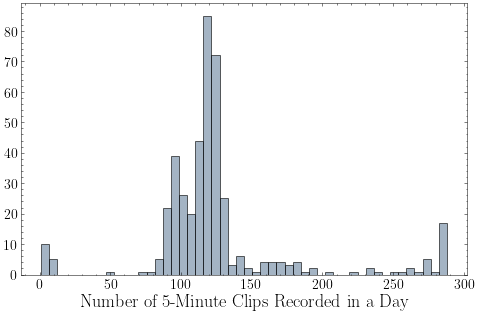

In [26]:
plt.figure(figsize=(8,5))
plt.hist(num_clips_per_day["num_per_station"].values, 50, alpha=0.6, edgecolor='black')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Number of 5-Minute Clips Recorded in a Day", size=18)
# plt.show()

plt.savefig('img/num_clips_per_day.pdf', bbox_inches='tight') 


## Figure 1 Right: Number of recordings, aggregated by hour

In [20]:
# How many clips per hour? (Aggregating all stations and countries in Africa)
num_rec_by_hour = df.groupby(['local_hour'])['location'].count().reset_index()
num_rec_by_hour.columns=["local_hour", "count"]

In [21]:
num_rec_by_hour["count_norm"] = num_rec_by_hour["count"] / num_rec_by_hour["count"].sum() * 100

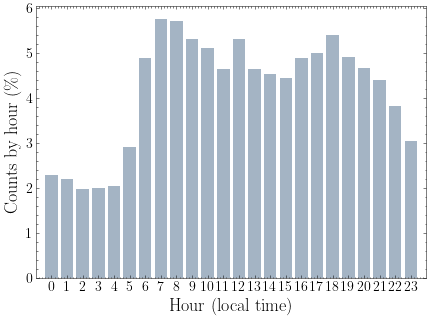

In [29]:
# Figure 1 Right
plt.figure(figsize=(8,5))
plt.bar(x=num_rec_by_hour['local_hour'], height=num_rec_by_hour['count_norm'], alpha=0.6)
plt.ylabel('Counts by hour (\%)', size=18)
plt.yticks(size=14)
plt.xlabel('Hour (local time)', size=18)
plt.xticks(range(0,24), size=14)
plt.xlim(-1,24)
# plt.show()

plt.savefig('img/num_clips_per_hour.pdf', bbox_inches='tight') 


(figure 1 right) gives more context to figure 1 left

24*12 = 288
Probability of how many clips you will find in a given day


Text(0.5, 1.0, 'How many clips recorded (agg across all countries) per day?')

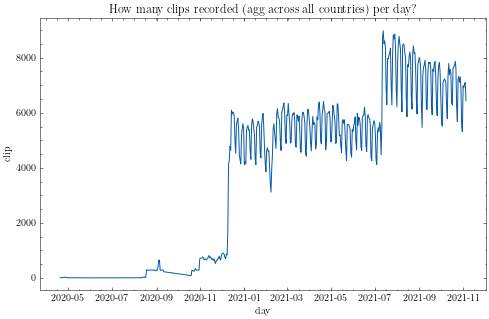

In [118]:
plt.figure(figsize=(8,5))

sns.lineplot(data=num_clips_per_day, x='day', y='clip')
plt.title('How many clips recorded (agg across all countries) per day?')

In [228]:
df.groupby(['day', 'name'])['clip'].count().reset_index()

day                       name  clip
0     2020-04-20                       96.3     1
1     2020-04-28                       94.4     2
2     2020-04-28                       95.5    11
3     2020-04-28                       96.3    13
4     2020-04-30                       95.5     2
...          ...                        ...   ...
19838 2021-11-05                  WazobiaFM   171
19839 2021-11-05                     WestFM   155
19840 2021-11-05                  Yanasalam    39
19841 2021-11-05                     ZNBCR1   145
19842 2021-11-05  ZodiacBroadcastingStation   162

[19843 rows x 3 columns]